<a href="https://colab.research.google.com/github/DanielGAMNA/TC4034_EQUIPO8/blob/main/Proyecto_Avance_3_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


**MAESTRÍA EN INTELIGENCIA ARTIFICIAL APLICADA**

Tecnológico de Monterrey

Análisis de grandes volúmenes de datos

Dr. Néstor Velasco Bermeo

*   A00759664 Joel Orlando Hernández Ramos
*   A01793031 María de los Ángeles Rabelero Campos
*   A01794498 Daniel Gómez Álvarez

## **8.2 Avance de proyecto 3:**  Sistema de recomendación - Retroalimentación Implícita

En este ejercicio, trabajaremos con preferencias implícitas en los datos, explorando técnicas para interpretar y aprovechar estas señales sutiles y generar recomendaciones precisas.

* Analiza cualquier modificación requerida para el alcance del proyecto.
* Realiza la comparación de diferentes algoritmos de recomendación de las actividades 4.2 y 6.2, en términos de rendimiento y escalabilidad.


Este enfoque empieza en el paso 15.


### 1. Importamos las librerias

In [291]:
# Manipulacion de datos
import numpy as np
import pandas as pd

# Visualizacion
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Similitud de cosenos
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

### 2. Importamos e inspeccionaos el dataset hospedado en Github

In [292]:
df = pd.read_csv("https://raw.githubusercontent.com/Melonangie/MNA/main/BigBasket%20Products.csv", index_col='index')
print(df.shape)
print(df.head())

(27555, 9)
                                                 product  \
index                                                      
1                 Garlic Oil - Vegetarian Capsule 500 mg   
2                                  Water Bottle - Orange   
3                         Brass Angle Deep - Plain, No.2   
4      Cereal Flip Lid Container/Storage Jar - Assort...   
5                     Creme Soft Soap - For Hands & Body   

                     category           sub_category              brand  \
index                                                                     
1            Beauty & Hygiene              Hair Care  Sri Sri Ayurveda    
2      Kitchen, Garden & Pets  Storage & Accessories         Mastercook   
3        Cleaning & Household            Pooja Needs                Trm   
4        Cleaning & Household   Bins & Bathroom Ware             Nakoda   
5            Beauty & Hygiene       Bath & Hand Wash              Nivea   

       sale_price  market_price           

### 3. Iniciamos el Análisis exploratorio de datos (EDA)

Si los datos son nulos o faltan, no podemos usarlos para el análisis de datos.

In [293]:
print('-'*38)
print('Datos nulos por columna')
print('-'*38)
print(df.isnull().sum())
print('-'*38)
print('Porcentaje de datos nulos por columna')
print('-'*38)
for col in df.columns:
    null_count = df[col].isnull().sum()
    total_count = df.shape[0]
    print("{} : {:.2f}".format(col,null_count/total_count * 100))

--------------------------------------
Datos nulos por columna
--------------------------------------
product            1
category           0
sub_category       0
brand              1
sale_price         0
market_price       0
type               0
rating          8626
description      115
dtype: int64
--------------------------------------
Porcentaje de datos nulos por columna
--------------------------------------
product : 0.00
category : 0.00
sub_category : 0.00
brand : 0.00
sale_price : 0.00
market_price : 0.00
type : 0.00
rating : 31.30
description : 0.42


**Podemos observar:**
*   Hay un producto sin nombre.
*   Hay un producto sin marca.
*   115 productos no tienen descripción.
*   8626 productos no tienen valoraciones.

### 4. Borramos las lineas que les falte informacion
Eliminaremos las filas de los datos que contienen valores faltantes.

In [294]:
df = df.dropna()
df.shape

(18840, 9)

### 5. Analizamos la distribución de la columna Category

In [295]:
counts = df['category'].value_counts()
count_percentage = df['category'].value_counts(1)*100
counts_df = pd.DataFrame({'Categoria':counts.index,'Total':counts.values,'Porcentaje':np.round(count_percentage.values,2)})
display(counts_df)

,Categoria,Total,Porcentaje
0,Beauty & Hygiene,5460,28.98
1,"Kitchen, Garden & Pets",2494,13.24
2,Snacks & Branded Foods,2468,13.10
3,Gourmet & World Food,2364,12.55
4,"Foodgrains, Oil & Masala",2173,11.53
5,Cleaning & Household,2091,11.10
6,"Bakery, Cakes & Dairy",665,3.53
7,Beverages,630,3.34
8,Baby Care,495,2.63


In [296]:
px.bar(data_frame=counts_df,
  x='Categoria',
  y='Total',
  color='Total',
  color_continuous_scale='blues',
  text_auto=True,
  title=f'Total de Artículos por Categoría')

**Podemos observar:**
*   Beauty & Hygiene tiene 5460 productos, es el 28,98% del total de productos.
*   Kitchen, Garden & Pets tiene 2494 productos, es el 13,24% del total de productos.
*   Baby Care tiene 495 productos, es el 2,63% del total de productos.

### 6. Analizamos la distribución de la columna sub_category

---



In [297]:
counts = df['sub_category'].value_counts()
count_percentage = df['sub_category'].value_counts(1)*100
counts_df = pd.DataFrame({'Subcategoría':counts.index,'Total':counts.values,'Porcentaje':np.round(count_percentage.values,2)})
print('Valores únicos por Subcategoría',df['sub_category'].nunique())

Valores únicos por Subcategoría 77


In [298]:
print('Top 10 Subcategorías')
display(counts_df.head(10))

Top 10 Subcategorías


,Subcategoría,Total,Porcentaje
0,Skin Care,1641,8.71
1,Hair Care,818,4.34
2,Bath & Hand Wash,808,4.29
3,Masalas & Spices,764,4.06
4,Storage & Accessories,658,3.49
5,Men's Grooming,649,3.44
6,Fragrances & Deos,627,3.33
7,Crockery & Cutlery,621,3.30
8,Ready To Cook & Eat,557,2.96
9,Organic Staples,550,2.92


In [299]:
print('Ultimas 10 Subcategorías')
display(counts_df.tail(10))

Ultimas 10 Subcategorías


,Subcategoría,Total,Porcentaje
67,Flask & Casserole,39,0.21
68,Car & Shoe Care,39,0.21
69,Bakeware,37,0.20
70,Non Dairy,31,0.16
71,Baby Accessories,27,0.14
72,Bakery Snacks,24,0.13
73,Mothers & Maternity,23,0.12
74,Water,16,0.08
75,Gourmet Breads,10,0.05
76,Cuts & Sprouts,1,0.01


In [300]:
px.bar(data_frame=counts_df[:10],
  x='Subcategoría',
  y='Total',
  color='Total',
  color_continuous_scale='blues',
  text_auto=True,
  title=f'Top 10 Subcategorías más compradas')

In [301]:
px.bar(data_frame=counts_df[-10:],
  x='Subcategoría',
  y='Total',
  color='Total',
  color_continuous_scale='blues',
  text_auto=True,
  title=f'Ultimas 10 Subcategorías más compradas')

**Podemos observar:**
*   Hay 77 valores de subcategoría únicos.
*   Skin Care tiene 1641 productos, es el 8,71% del total de productos.
*   Hair Care tiene 818 productos, es el 4,34% del total de productos.
*   Cuts & Sprouts tiene 1 producto, es el 0,01% del total de productos.

### 7. Analizamos la distribución de la columna Brand

In [302]:
column = 'brand'
counts = df[column].value_counts()
count_percentage = df[column].value_counts(1)*100
counts_df = pd.DataFrame({'Marca':counts.index,'Total':counts.values,'Porcentaje':np.round(count_percentage.values,2)})
print('Valores únicos por Marca',df['sub_category'].nunique())

Valores únicos por Marca 77


In [303]:
print('Top 10 Marcas')
counts_df.head(10)

Top 10 Marcas


,Marca,Total,Porcentaje
0,bb Royal,278,1.48
1,BB Home,172,0.91
2,Amul,153,0.81
3,Himalaya,139,0.74
4,Cello,104,0.55
5,BIOTIQUE,103,0.55
6,DP,101,0.54
7,Keya,101,0.54
8,Organic Tattva,99,0.53
9,MTR,97,0.51


In [304]:
print('Ultimas 10 Marcas')
counts_df.tail(10)

Ultimas 10 Marcas


,Marca,Total,Porcentaje
1923,Diabetics Dezire,1,0.01
1924,Kerala,1,0.01
1925,Cetaphil,1,0.01
1926,Popular Essentials,1,0.01
1927,Sanitt,1,0.01
1928,Fazlani,1,0.01
1929,Fakira,1,0.01
1930,Sofia,1,0.01
1931,Dr. Schar,1,0.01
1932,4700BC,1,0.01


In [305]:
px.bar(data_frame=counts_df.head(10),
  x='Marca',
  y='Total',
  color='Total',
  color_continuous_scale='blues',
  text_auto=True,
  title=f'Top 10 artículos por marca según el total de artículos')

**Podemos observar:**
*   Hay 1933 valores únicos para las marcas.
*   Hay 494 marcas que tienen un solo producto.
*   bb Royal tiene 278 productos, es el 1,48% del total de productos.
*   BB Home tiene 172 productos, es el 0,91% del total de productos.

### 8. Analizamos la distribución de la columna Type



In [306]:
column = 'type'
counts = df[column].value_counts()
count_percentage = df[column].value_counts(1)*100
counts_df = pd.DataFrame({'Tipo de producto':counts.index,'Total':counts.values,'Porcentaje':np.round(count_percentage.values,2)})
print('Valores únicos por Tipo de productos',df[column].nunique())

Valores únicos por Tipo de productos 358


In [307]:
print('Top 10 Tipos de productos')
display(counts_df.head(10))

Top 10 Tipos de productos


,Tipo de producto,Total,Porcentaje
0,Face Care,1094,5.81
1,Men's Deodorants,404,2.14
2,Shampoo & Conditioner,390,2.07
3,Blended Masalas,343,1.82
4,Containers Sets,332,1.76
5,Bathing Bars & Soaps,322,1.71
6,Glassware,263,1.40
7,Body Care,251,1.33
8,Namkeen & Savoury Snacks,234,1.24
9,Hand Wash & Sanitizers,212,1.13


In [308]:
px.bar(data_frame=counts_df.head(10),
  x='Tipo de producto',
  y='Total',
  color='Total',
  color_continuous_scale='blues',
  text_auto=True,
  title=f'Top 10 Tipo de producto')

**Podemos observar:**
*   Hay 358 tipos de productos.
*   Existen 9 clasificaciones de tipos de productos con un solo producto.
*   Facial Care tiene 1094 productos, es el 5,81% del total de productos.
*   Men's Deodorants tiene 404 productos, es el 2,14% del total de productos.

### 9. Análisis de Ratings

Observemos el histograma de la columna "rating".

count    18840.000000
mean         3.943063
std          0.739646
min          1.000000
25%          3.700000
50%          4.100000
75%          4.300000
max          5.000000
Name: rating, dtype: float64


<Axes: >

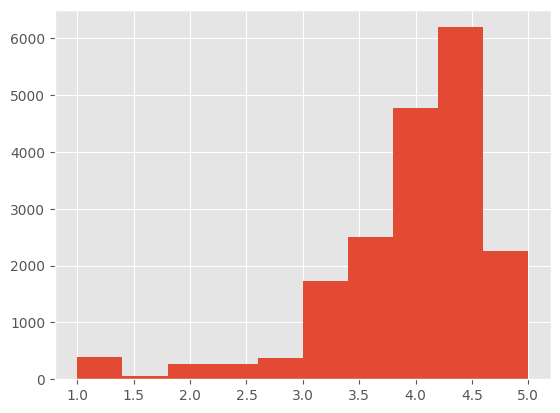

In [309]:
print(df['rating'].describe())
df['rating'].hist(bins=10)

Podemos ver que el histograma está inclinado a la derecha,  porque
los productos tienen una calificación más alta.

Observemos las calificaciones por intervalos.

In [310]:
pd.cut(df.rating,bins = [0,1,2,3,4,5]).reset_index().groupby(['rating']).size()

rating
(0, 1]      387
(1, 2]      335
(2, 3]     1347
(3, 4]     6559
(4, 5]    10212
dtype: int64

**Podemos observar:**
*   10212 productos tienen una calificación entre 4 y 5.
*   387 productos tienen una calificación entre 0 y 1.

### 10. Analisis de Features

Vamos a seleccionar los features para las recomendaciones. Comenzaremos creando el feature descuento

In [311]:
df['descuento'] = (df['market_price']-df['sale_price'])*100/df['market_price']
df['descuento'].describe()

count    18840.000000
mean        11.751733
std         14.546937
min          0.000000
25%          0.000000
50%          5.000000
75%         20.000000
max         82.506266
Name: descuento, dtype: float64

Observemos los descuentos por intervalos y su histograma.

In [312]:
pd.cut(df.descuento,bins = [-1,0,10,20,30,40,50,60,80,90,100]).reset_index().groupby(['descuento']).size()

descuento
(-1, 0]      8157
(0, 10]      3125
(10, 20]     2962
(20, 30]     2435
(30, 40]     1126
(40, 50]      700
(50, 60]      223
(60, 80]      108
(80, 90]        4
(90, 100]       0
dtype: int64

<Axes: >

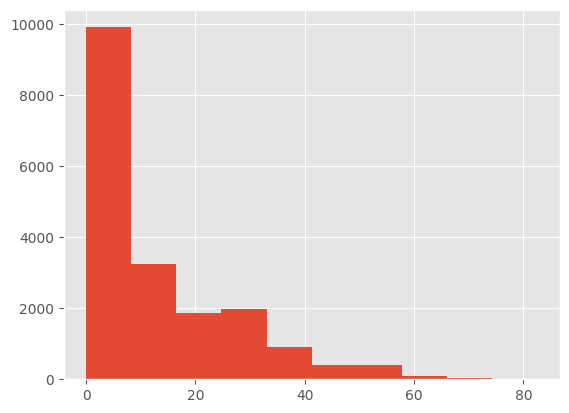

In [313]:
df['descuento'].hist()

**Podemos observar:**
*   8157 productos no tienen ningún descuento.
*   Al menos 4 productos tienen más del 80% de descuento.

### 11. Creacion de Features

Limpiamos y transformamos las columnas siguientes para crear el feature features_clasificacion_de_productos que agregara las columnas ya limpias y transformadas.
*   Kitchen, Garden & Pets
*   sub_category
*   type
*   brand

In [314]:
df2 = df.copy()
rmv_spc = lambda a:a.strip()
get_list = lambda a:list(map(rmv_spc,re.split(r'& |, |\*|n', a)))

for col in ['category', 'sub_category', 'type']:
    df2[col] = df2[col].apply(get_list)

def cleaner(x):
    if isinstance(x, list):
        return [str.lower(i.replace(" ", "")) for i in x]
    else:
        if isinstance(x, str):
            return str.lower(x.replace(" ", ""))
        else:
            return ''

for col in ['category', 'sub_category', 'type','brand']:
    df2[col] = df2[col].apply(cleaner)

def couple(x):
    return ' '.join(x['category']) + ' ' + ' '.join(x['sub_category']) + ' '+x['brand']+' ' +' '.join( x['type'])

df2['features_clasificacion_de_productos'] = df2.apply(couple, axis=1)

### 12. Construiremos la lógica para recomendaciones basadas en popularidad

Usaremos el feed de recomendación: tipo, categoría o subcategoría. Devolverá el producto más popular o el producto que tenga la calificación más alta.

In [315]:
def recomendacion_mas_popular(col,col_value,top_n=5):
  return df[df[col]==col_value].sort_values(by='rating',ascending = False).head(top_n)[['product',col,'rating']]

Observemos los productos más populares de la categoría Beauty & Hygiene

In [316]:
recomendacion_mas_popular(col='category',col_value='Beauty & Hygiene')

,product,category,rating
index,,,
20164,Supreme Scalp Rejuvenation Shampoo,Beauty & Hygiene,5.0
5472,Vitamin C Brightening Day Cream With SPF 30 UV...,Beauty & Hygiene,5.0
20936,Exfoliating Face Scrub,Beauty & Hygiene,5.0
5499,Prickly Heat Powder - Cool Chandan With Sandal...,Beauty & Hygiene,5.0
20860,Wheat Grass Powder,Beauty & Hygiene,5.0


:Observemos los productos más populares para sub_categoría Hair Care

In [317]:
recomendacion_mas_popular(col='sub_category',col_value='Hair Care')

,product,sub_category,rating
index,,,
14617,Black Pearl Shampoo - Hair Loss & Dandruff Con...,Hair Care,5.0
8275,"De-Tangling Comb - 1 Row, 1266",Hair Care,5.0
14556,Argan Oil Shampoo,Hair Care,5.0
14441,Blooming Colour Shampoo - Murumuru Butter & Ro...,Hair Care,5.0
13070,Hair Repair Conditioner,Hair Care,5.0


Observemos los productos más populares de la marca Amul

In [318]:
recomendacion_mas_popular(col='brand',col_value='Amul')

,product,brand,rating
index,,,
16467,Vanilla Milkshake,Amul,5.0
10431,Spray Infant Milk Food/Substitute,Amul,4.5
5857,Almondo - Roasted Almonds Coated With Milk Cho...,Amul,4.5
9400,Amulya Dairy Whitener,Amul,4.4
20842,"Peru Dark Amazon, Single Origin Dark Chocolate...",Amul,4.4


Observemos los productos más populares por tipo Face Care

In [319]:
recomendacion_mas_popular(col='type',col_value='Face Care')

,product,type,rating
index,,,
16906,Nutritivo Pomegranate Radiant Glow Firming Serum,Face Care,5.0
25347,Hydro Replenish Refreshing Face Mist,Face Care,5.0
9286,Bio Morning Nectar Flawless Skin Cream,Face Care,5.0
3356,Total Effects Whip - UV SPF 30,Face Care,5.0
3369,Organic Shield - Anti Tan Facial Kit,Face Care,5.0


### 13. Construiremos un sistema de recomendación basado en contenido

Usaremos los metadatos de los producto como la categoría, subcategoría, tipo, precio, etc. Extraeremos productos similares de en función de estas features. Y `CountVectorizer` para crear features que representan el recuento de apariciones de una palabra.

Una vez que tengamos estos vectores, usaremos la distancia de coseno para identificar y recomendar productos similares.

Empezaremos calculando la similitud de coseno entre el feature `features_clasificacion_de_productos` y todos los productos.

In [320]:
conteo = CountVectorizer(stop_words='english')
matriz_conteo = conteo.fit_transform(df2['features_clasificacion_de_productos'])
coseno_sim = cosine_similarity(matriz_conteo, matriz_conteo)
coseno_sim_df = pd.DataFrame(coseno_sim)

La matriz `coseno_sim_df` contiene la similitud coseno entre cada producto y el resto de los productos. Construiremos un recomendador usando la similitud de coseno.

In [321]:
def recomendacion_de_contenido(titulo):
    a = df2.copy().reset_index().drop('index', axis=1)
    index = a[a['product'] == titulo].index[0]
    top_n_index = list(coseno_sim_df[index].nlargest(10).index)
    try:
        top_n_index.remove(index)
    except:
        pass
    similar_df = a.iloc[top_n_index][['product']]
    similar_df['similaridad_coseno'] = coseno_sim_df[index].iloc[top_n_index]
    return similar_df

Observemos las recomendaciones de un producto. Una botella de agua naranja.:

In [322]:
recomendacion_de_contenido('Water Bottle - Orange')

,product,similaridad_coseno
109,Glass Water Bottle - Aquaria Organic Purple,0.875
705,Glass Water Bottle With Round Base - Transpare...,0.875
1155,H2O Unbreakable Water Bottle - Pink,0.875
1500,Water Bottle H2O Purple,0.875
1828,H2O Unbreakable Water Bottle - Green,0.875
1976,Regel Tritan Plastic Sports Water Bottle - Black,0.875
2182,Apsara 1 Water Bottle - Assorted Colour,0.875
2361,"Glass Water Bottle With Round Base - Yellow, B...",0.875
2485,Trendy Stainless Steel Bottle With Steel Cap -...,0.875


**Podemos observar:**
*   Podemos recomendar botellas. Pero se recomeindan todos los colores.
*   La recomendación principal debería ser naranja.
*   La similitud del coseno es la misma para todas las recomendaciones.

### 14. Mejorando el Algoritmo

Usaremos la columna `product` para crear otra similitud de coseno. Tomaremos el promedio de la similitud de ambos cosenos y veremos si los resultados son mejores.

In [323]:
conteo2 = CountVectorizer(stop_words='english', lowercase=True)
matriz_conteo2 = conteo2.fit_transform(df2['product'])
coseno_sim2 = cosine_similarity(matriz_conteo2, matriz_conteo2)
coseno_sim_df2 = pd.DataFrame(coseno_sim2)

Construiremos una nueva version del recomendador usando la similitud de coseno.

In [324]:
def recomendacion_de_contenido_v2(titulo):
    a = df2.copy().reset_index().drop('index', axis=1)
    index = a[a['product'] == titulo].index[0]
    metrica_basica_similar_1 = coseno_sim_df[coseno_sim_df[index] > 0][index].reset_index().rename(columns = {index:'sim_1'})
    metrica_basica_similar_2 = coseno_sim_df2[coseno_sim_df2[index] > 0][index].reset_index().rename(columns = {index:'sim_2'})
    similar_df = metrica_basica_similar_1.merge(metrica_basica_similar_2, how='left').merge(a[['product']].reset_index(), how='left')
    similar_df['sim'] = similar_df[['sim_1', 'sim_2']].fillna(0).mean(axis=1)
    similar_df = similar_df[similar_df['index'] != index].sort_values(by='sim', ascending=False)
    return similar_df[['product', 'sim']].head(10)

Observemos nuevamente las recomendaciones del mismo producto anterior. Una botella de agua naranja.

In [325]:
recomendacion_de_contenido_v2('Water Bottle - Orange')

,product,sim
2568,Swat Pet Water Bottle - Orange,0.824798
672,Sante Infuser Water Bottle - Orange,0.824798
2027,H2o Unbreakable Water Bottle - Orange,0.824798
1915,Glass Water Bottle - Circo Orange & Lemon,0.791053
2088,Spray Glass water Bottle With Cork - Orange,0.791053
1927,Sip-It-Plastic Water Bottle,0.726175
2000,"Water Bottle - Twisty, Pink",0.726175
194,Water Bottle H2O Purple,0.726175
1291,Plastic Water Bottle - Pink,0.726175
1878,Whip Insulated Water Bottle - Red,0.695699


**Podemos observar:**
*   Los resultados son mucho mejores en esta ocacion.
*   Las botellas de color naranja tienen una mayor similitud.

Ahora observemos las recomendaciones de chocolate oscuro.

In [326]:
recomendacion_de_contenido_v2('Dark Chocolate- 55% Rich In Cocoa')

,product,sim
446,"Fruit N Nut, Dark Chocolate- 55% Rich In Cocoa",0.922577
2403,Sugar Free Dark Chocolate- 55% Rich In Cocoa,0.922577
2782,Rich Cocoa Dark Chocolate Bar,0.850000
574,Dark Chocolate,0.816228
516,Dlite Rich Cocoa Dark Chocolate Bar,0.815148
3210,Bitter Chocolate- 75% Rich In Cocoa,0.800000
3222,Bournville Rich Cocoa 70% Dark Chocolate Bar,0.788062
2608,"Peru Dark Amazon, Single Origin Dark Chocolate...",0.782843
560,"Colombia Classique Black, Single Origin Dark C...",0.769680
1755,"Madagascar Noir De Cacao, Single Origin Dark C...",0.769680


**Podemos observar:**
*   Los productos de chocolate oscuro tienen mayores similitudes.

Finalmente observemos las recomendaciones para chips.

In [327]:
recomendacion_de_contenido_v2('Nacho Round Chips')

,product,sim
3776,Nacho Chips - Crunchy Pizza,0.788675
718,Nacho Chips - Jalapeno,0.770833
3640,Nacho Chips - Cheese,0.770833
1683,Nacho Chips - Salsa,0.770833
464,Nacho Chips - Peri Peri,0.735702
3922,Nacho Chips - Roasted Masala,0.726175
3148,Nacho Chips - Sweet Chilli,0.726175
4488,"Nacho Chips - Jalapeno, No Onion, No Garlic",0.695699
1236,Nacho Chips - Peri Peri,0.673202
86,"Nacho Chips - Cheese With Herbs, No Onion, No ...",0.673202


**Podemos observar:**
*   Los resultados de la recomendación son relevantes.

### 15. Retroalimentación Implícita usando Filtrado Coloborativo

La Retroalimentación Implícita se basa en datos de comportamiento del usuario para identificar patrones y hacer recomendaciones basadas en preferencias de usuario similares.

En este caso, se utilizara otro [conjunto de datos](https://www.kaggle.com/datasets/skillsmuggler/amazon-ratings/data) porque esta técnica utiliza las calificaciones de otros clientes.

#### Importamos las librerias y el dataset

In [328]:
import sklearn
from sklearn.decomposition import TruncatedSVD
plt.style.use("ggplot")

In [329]:
df3 = pd.read_csv('https://github.com/Melonangie/MNA/raw/main/ratings_Beauty.zip')

#### **Iniciamos EDA**

In [330]:
df3.head()

,UserId,ProductId,Rating,Timestamp
0,A39HTATAQ9V7YF,0205616461,5.0,1369699200
1,A3JM6GV9MNOF9X,0558925278,3.0,1355443200
2,A1Z513UWSAAO0F,0558925278,5.0,1404691200
3,A1WMRR494NWEWV,0733001998,4.0,1382572800
4,A3IAAVS479H7M7,0737104473,1.0,1274227200


In [331]:
df3.isnull().sum()

UserId       0
ProductId    0
Rating       0
Timestamp    0
dtype: int64

In [332]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2023070 entries, 0 to 2023069
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   UserId     object 
 1   ProductId  object 
 2   Rating     float64
 3   Timestamp  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 61.7+ MB


In [333]:
print('Número de usuarios: ', len(df3.UserId.unique()))
print('Número de artículos: ', len(df3.ProductId.unique()))
print('Número de calificaciones: ', df3.shape[0])

for i in reversed(range(1, 6)):
    print('Porcentaje de artículos con calificacion {}: {:.2f}%'.format(i, len(df3[df3.Rating==i]['ProductId'].unique()) / len(df3.ProductId.unique()) * 100 ))

Número de usuarios:  1210271
Número de artículos:  249274
Número de calificaciones:  2023070
Porcentaje de artículos con calificacion 5: 80.57%
Porcentaje de artículos con calificacion 4: 36.17%
Porcentaje de artículos con calificacion 3: 26.12%
Porcentaje de artículos con calificacion 2: 20.04%
Porcentaje de artículos con calificacion 1: 26.50%


<Axes: xlabel='Rating'>

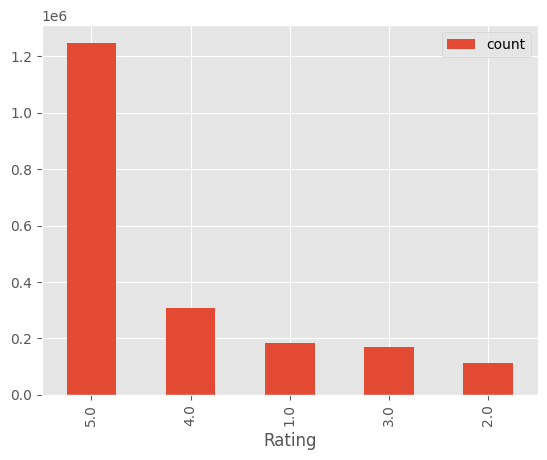

In [334]:
df3.Rating.value_counts().to_frame().plot(kind='bar')

In [335]:
productos_populares = pd.DataFrame(df3.groupby('ProductId')['Rating'].count())
productos_mas_populares = productos_populares.sort_values('Rating', ascending=False)
productos_mas_populares.head(10)

,Rating
ProductId,
B001MA0QY2,7533
B0009V1YR8,2869
B0043OYFKU,2477
B0000YUXI0,2143
B003V265QW,2088
B000ZMBSPE,2041
B003BQ6QXK,1918
B004OHQR1Q,1885
B00121UVU0,1838


<Axes: xlabel='ProductId'>

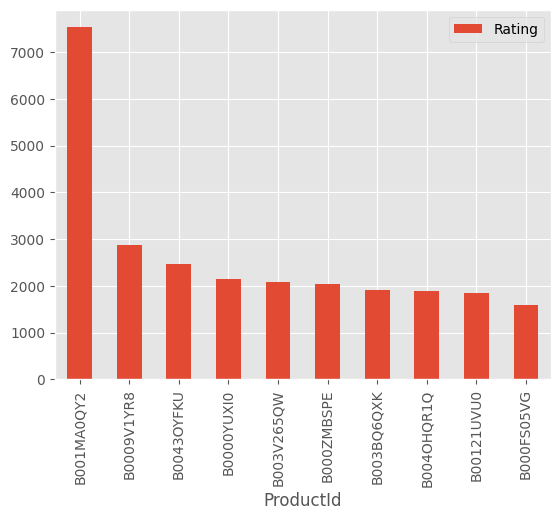

In [336]:
productos_mas_populares.head(10).plot(kind = "bar")

#### **Iniciamos el Filtrado Colaborativo para recomendaciones implicitas**

Creamos una matriz de elementos de usuario a partir del conjunto de datos. Esta matriz representa las interacciones usuario-articulo, donde las filas corresponden a los usuarios, las columnas corresponden a los elementos y los valores representan las calificaciones otorgadas por los usuarios a los elementos. La matriz es escasa, ya que ningun usuarios compraría todos los artículos, por lo que la mayoría de los valores son desconocidos y se rellenaran con 0.

Se creara un subconjunto de los primeros 10000 articulos debido al tamano.

In [337]:
sub_df3 = df3.head(10000)
matriz_usuario_articulo = sub_df3.pivot_table(index='UserId', columns='ProductId', values='Rating', fill_value=0)
matriz_usuario_articulo.head()

ProductId,0205616461,0558925278,0733001998,0737104473,0762451459,1304139212,1304139220,130414089X,130414643X,1304146537,...,B000052YPE,B000052YPF,B000052YPG,B000052YPH,B000052YPM,B000052YPU,B000052YPV,B000052YPY,B000052YQ0,B000052YQ2
UserId,,,,,,,,,,,,,,,,,,,,,
A00205921JHJK5X9LNP42,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A024581134CV80ZBLIZTZ,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A03056581JJIOL5FSKJY7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A03099101ZRK4K607JVHH,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A0505229A7NSH3FRXRR4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Transponemos la matriz, y creamos un subconjunto de productos únicos.

In [338]:
X = matriz_usuario_articulo.T
X1 = X
X.head()

UserId,A00205921JHJK5X9LNP42,A024581134CV80ZBLIZTZ,A03056581JJIOL5FSKJY7,A03099101ZRK4K607JVHH,A0505229A7NSH3FRXRR4,A05492663T95KW63BR75K,A059547920Q3LZVFHLPI3,A07410232KYRFR25CIUGJ,A082796624UNM47DSAI6K,A0864963DOAY7LXGS5I6,...,AZW1HXXYAC15B,AZWRTJPN7NXT,AZWTXHXZXFAYP,AZYQEFB9Y5N22,AZZHB6U54UDYW,AZZHJZP4GQPPZ,AZZNK89PXD006,AZZOFVMQC0BJG,AZZQXL8VDCFTV,AZZTJQ7CQZUD8
ProductId,,,,,,,,,,,,,,,,,,,,,
0205616461,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0558925278,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0733001998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0737104473,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0762451459,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


La descomposición de valores singulares (SVD) nos va a ayudar a reducir la dimensionalidad de la matriz. TruncatedSVD es similar al SVD tradicional pero produce una aproximación de la matriz original considerando solo los k valores singulares superiores y sus correspondientes vectores singulares.

Descomponemos la matriz.

In [339]:
SVD = TruncatedSVD(n_components=10)
matriz_decomposiscion = SVD.fit_transform(X)
matriz_decomposiscion

array([[-1.75715936e-16, -4.83700825e-14, -1.35322537e-13, ...,
         3.39919260e-14, -1.07007967e-12,  7.11116444e-12],
       [-9.07497602e-15,  6.90607864e-13,  1.09214181e-12, ...,
         1.19984144e-12,  1.11699740e-11, -6.26457758e-11],
       [ 3.03591534e-16, -1.13139463e-14, -4.29786246e-14, ...,
         7.77297466e-14,  3.95168242e-14,  2.55942898e-12],
       ...,
       [ 3.42557603e-06,  2.27950249e-01, -1.04068901e-02, ...,
        -3.75540988e-03, -2.24987789e-05, -4.83652798e-02],
       [ 6.55824001e-06,  7.42016498e-04, -8.86301416e-05, ...,
         1.65861838e-04, -7.82960543e-05,  8.13265761e-03],
       [-2.38466896e-04,  4.24634200e-01,  3.60854599e-01, ...,
        -9.65569329e-03,  6.57318793e-02, -1.44752606e-01]])

Creamos una matriz de correlación.

In [340]:
matriz_correlacion = np.corrcoef(matriz_decomposiscion)
matriz_correlacion

array([[ 1.        , -0.99660049,  0.98693409, ..., -0.28743153,
         0.81671359, -0.37538034],
       [-0.99660049,  1.        , -0.97681074, ...,  0.29048937,
        -0.8532669 ,  0.31318626],
       [ 0.98693409, -0.97681074,  1.        , ..., -0.30873979,
         0.79609428, -0.44170492],
       ...,
       [-0.28743153,  0.29048937, -0.30873979, ...,  1.        ,
        -0.24080258,  0.25131587],
       [ 0.81671359, -0.8532669 ,  0.79609428, ..., -0.24080258,
         1.        ,  0.09875535],
       [-0.37538034,  0.31318626, -0.44170492, ...,  0.25131587,
         0.09875535,  1.        ]])

#### Correlacionamos articulos con usuarios

Correlaciónamos los artículos con otro artículo comprado por otro cliente, según la calificacion de otros clientes que compraron el mismo artículo. Obtenemos el ID de un artículo para ver sus correlaciones. Usamos el indice 101 de la matriz traspuesta como ejemplo.

In [341]:
id_producto = X.index[101]
id_producto

'6152000416'

In [342]:
indices = list(X.index)

indice_producto = indices.index(id_producto)
indice_producto

101

Obtenemos todas la correlaciónes de los artículos que están correlacionados con el ID del artículo que el usuario compro.

In [343]:
correlacion_id_productos = matriz_correlacion[indice_producto]

correlacion_id_productos.shape

(886,)

#### Recomendacion de los top 10 productos altamente correlacionados

Obtenemos los primeros 10 productos recomendados del indice eleguido al azar 101, basados en compras realizada por otros usuarios.

In [344]:
recomendaciones = list(X.index[correlacion_id_productos > 0.5])
top_recomendaciones = recomendaciones[0:10]
top_recomendaciones

['0558925278',
 '0737104473',
 '0762451459',
 '130414089X',
 '1304146537',
 '1304168522',
 '1304351475',
 '1304482634',
 '1304622428',
 '1403790965']

Creamos un diccionario para mapear el ID de un artículo con el nombre de un producto del dataset anterior. Y obtenemos los nombres de las recomendaciones anteriores.

In [345]:
dic_nombres=dict(list(zip(indices, df['product'].values.tolist())))

list(dic_nombres.items())[:10]

[('0205616461', 'Garlic Oil - Vegetarian Capsule 500 mg'),
 ('0558925278', 'Water Bottle - Orange'),
 ('0733001998', 'Brass Angle Deep - Plain, No.2'),
 ('0737104473', 'Cereal Flip Lid Container/Storage Jar - Assorted Colour'),
 ('0762451459', 'Creme Soft Soap - For Hands & Body'),
 ('1304139212', 'Germ - Removal Multipurpose Wipes'),
 ('1304139220', 'Multani Mati'),
 ('130414089X', 'Hand Sanitizer - 70% Alcohol Base'),
 ('130414643X',
  'Biotin & Collagen Volumizing Hair Shampoo + Biotin & Collagen Hair Conditioner'),
 ('1304146537', 'Scrub Pad - Anti- Bacterial, Regular')]

In [346]:
[dic_nombres[i] for i in top_recomendaciones]

['Water Bottle - Orange',
 'Cereal Flip Lid Container/Storage Jar - Assorted Colour',
 'Creme Soft Soap - For Hands & Body',
 'Hand Sanitizer - 70% Alcohol Base',
 'Scrub Pad - Anti- Bacterial, Regular',
 'Butter Cookies Gold Collection',
 'Organic Tofu - Soy Paneer',
 'Instant Noodles - Chicken Satay Flavor',
 'Pet Solitaire Container Set - Silver',
 'Pani Puri Mix Paste']

In [347]:
def recomendacion_de_contenido_implicita(id_producto):
    indice_producto = indices.index(id_producto)
    correlacion_id_productos = matriz_correlacion[indice_producto]
    recomendaciones = list(X.index[correlacion_id_productos > 0.9])
    return [dic_nombres[i] for i in recomendaciones[0:10]]

Obtenemos las recomendaciones del articulo con ID 0737104473

In [348]:
recomendacion_de_contenido_implicita('0737104473')

['Water Bottle - Orange',
 'Cereal Flip Lid Container/Storage Jar - Assorted Colour',
 'Creme Soft Soap - For Hands & Body',
 'Hand Sanitizer - 70% Alcohol Base',
 'Organic Tofu - Soy Paneer',
 'Instant Noodles - Chicken Satay Flavor',
 'Pani Puri Mix Paste',
 'Peach Syrup',
 'Choco Deck - French Dessert Inspired Layered Bar',
 'Foochka']

### 16. Comparacion de Algoritmos

In [349]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

In [350]:
%%time
recomendacion_mas_popular(col='type',col_value='Face Care')

CPU times: user 7.3 ms, sys: 0 ns, total: 7.3 ms
Wall time: 23.3 ms


,product,type,rating
index,,,
16906,Nutritivo Pomegranate Radiant Glow Firming Serum,Face Care,5.0
25347,Hydro Replenish Refreshing Face Mist,Face Care,5.0
9286,Bio Morning Nectar Flawless Skin Cream,Face Care,5.0
3356,Total Effects Whip - UV SPF 30,Face Care,5.0
3369,Organic Shield - Anti Tan Facial Kit,Face Care,5.0


In [351]:
%%time
recomendacion_de_contenido('Water Bottle - Orange')

CPU times: user 44.5 ms, sys: 0 ns, total: 44.5 ms
Wall time: 67.2 ms


,product,similaridad_coseno
109,Glass Water Bottle - Aquaria Organic Purple,0.875
705,Glass Water Bottle With Round Base - Transpare...,0.875
1155,H2O Unbreakable Water Bottle - Pink,0.875
1500,Water Bottle H2O Purple,0.875
1828,H2O Unbreakable Water Bottle - Green,0.875
1976,Regel Tritan Plastic Sports Water Bottle - Black,0.875
2182,Apsara 1 Water Bottle - Assorted Colour,0.875
2361,"Glass Water Bottle With Round Base - Yellow, B...",0.875
2485,Trendy Stainless Steel Bottle With Steel Cap -...,0.875


In [354]:
%%time
recomendacion_de_contenido_v2('Whip Insulated Water Bottle - Red')

CPU times: user 188 ms, sys: 146 ms, total: 333 ms
Wall time: 918 ms


,product,sim
1077,Whip Alloy Insulated Water Bottle - Pink,0.865148
2357,Sunshine Insulated Water Bottle - Blue,0.800000
911,Sunshine Insulated Water Bottle - Green,0.800000
1314,Sunshine Insulated Water Bottle - Pink,0.800000
1276,Sunshine Insulated Water Bottle - Green,0.800000
482,Sunshine Insulated Water Bottle - Yellow,0.800000
1875,Sante Infuser Water Bottle - Red,0.737500
668,Spray Glass Water Bottle With Cork - Red,0.711361
1662,Glass Water Bottle - Aquaria Organic Red,0.711361
2360,Loopy Pet water Bottle - Pink,0.700000


In [353]:
%%time
recomendacion_de_contenido_implicita('130414643X')

CPU times: user 255 µs, sys: 0 ns, total: 255 µs
Wall time: 263 µs


['Garlic Oil - Vegetarian Capsule 500 mg',
 'Brass Angle Deep - Plain, No.2',
 'Germ - Removal Multipurpose Wipes',
 'Multani Mati',
 'Biotin & Collagen Volumizing Hair Shampoo + Biotin & Collagen Hair Conditioner',
 'Wheat Grass Powder - Raw',
 'Face Wash - Oil Control, Active',
 'Mold & Mildew Remover with Bleach',
 'Just Spray - Mosquito Repellent Room Spray',
 'Dove Plastic Soap Case - Assorted Colour']